# Bayesian Neural Networks in PyMC3 with Stochastic Gradient Algorithms

To learn more about using bayesian methods, to train deep learning method please refer to this post by Thomas Wiecki http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/. This notebook
follows a similar structure.

## Stochastic Gradient Fisher Scoring

Author: [__shkr__](www.github.com/shkr)

```
Can we approximately sample from a Bayesian posterior distribution if we are only allowed to touch a small mini-batch of data-items for every sample we generate?
```


Stochastic Gradient Fisher scoring is an algorithm which at high mixing rates (or epsilon valuees) samples from a normal approximation of the 
posterior, while for slow mixing rates it will mimic the behaviour of SGLD with a preconditioner matrix that is as parameter `B`.

The mixing rate is controlled by epsilon which is $ \epsilon = 2^{-\frac{t}{step\_size\_decay}}*step\_size $


Here we run the sampling algorithm with a minibatch of the training samples of X_train.
The `total_size` is `X_train.shape[0]`. If the preconditioner matrix is not specified, an identity matrix is used.

Reference: https://www.slideshare.net/hustwj/austerity-in-mcmc-land-cutting-the-computational-budget

## Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable.

In [1]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

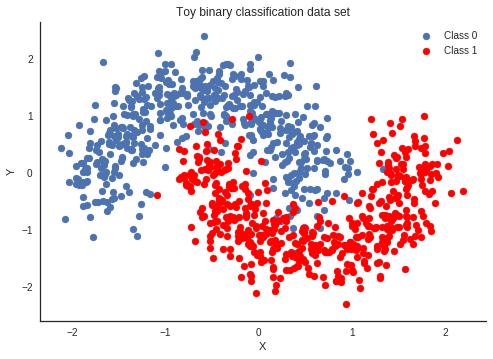

In [3]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

Store training data in Theano shared variables

In [4]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

## Model specification

A neural network is quite simple. The basic unit is a [perceptron](https://en.wikipedia.org/wiki/Perceptron) which is nothing more than [logistic regression](posterior_predictive.ipynb#Prediction). We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [5]:
total_size = len(Y_train)
n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_out = np.random.randn(n_hidden).astype(floatX)

def build_network(ann_input, ann_output):
    with pm.Model() as model:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,), 
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=total_size)
        
    return model, out

In [6]:
from six.moves import zip

def train_sgfs(model, B=None):
    
    # Tensors and RV that will be using mini-batches
    minibatch_tensors = [ann_input, ann_output]
    minibatch_RVs = [out]

    # Generator that returns mini-batches in each iteration
    def create_minibatch(data):
        rng = np.random.RandomState(0)

        while True:
            # Return random data samples of set size 50 each iteration
            ixs = rng.randint(len(data), size=50)
            yield data[ixs]

    minibatches = zip(
        create_minibatch(X_train), 
        create_minibatch(Y_train),
    )

    total_size = len(Y_train)

    with model:
        draws = 4500
        step_method = pm.SGFS(batch_size=50, 
                              total_size=total_size, 
                              B=B, 
                              step_size=.1, 
                              step_size_decay=100, 
                              minibatches=minibatches, 
                              minibatch_tensors=minibatch_tensors)
        trace = pm.sample(draws=draws, step=step_method)    
        return step_method, trace
    
neural_network, out = build_network(ann_input, ann_output)
%time step_method, trace = train_sgfs(neural_network)

/home/laoj/Documents/Github/pymc3/pymc3/step_methods/sgmcmc.py:107: UserWarning: Warning: Stochastic Gradient based sampling methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
100%|██████████| 5000/5000 [00:12<00:00, 408.54it/s]

CPU times: user 22.3 s, sys: 1min 11s, total: 1min 33s
Wall time: 14.7 s


A smaller wall time than mini-batch ADVI

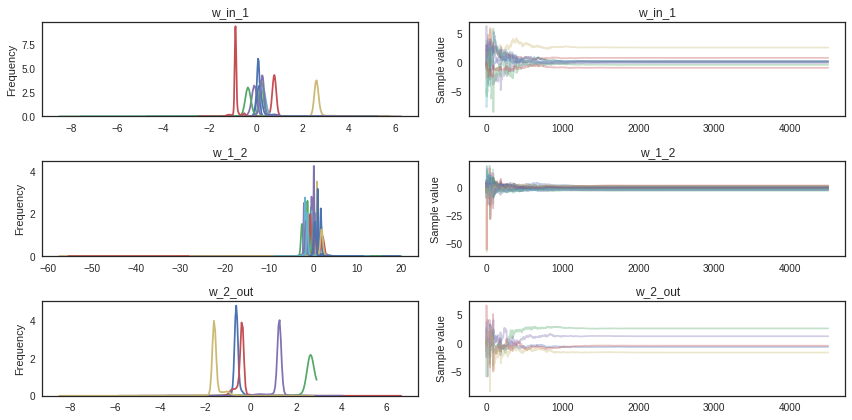

In [7]:
pm.traceplot(trace);

In [8]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500, random_seed=0)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

100%|██████████| 500/500 [00:00<00:00, 2345.24it/s]


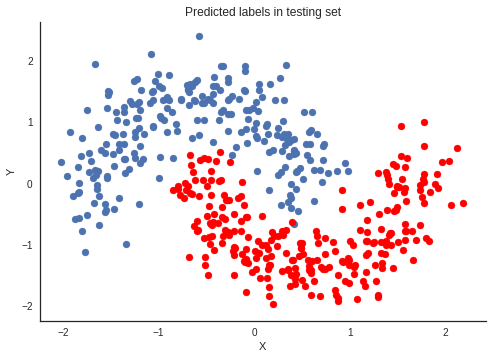

In [9]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [10]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 97.2%


### Lets look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [11]:
grid = np.mgrid[-3:3:100j,-3:3:100j].astype(floatX)
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [12]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500, random_seed=0)

100%|██████████| 500/500 [00:03<00:00, 148.52it/s]


### Probability surface

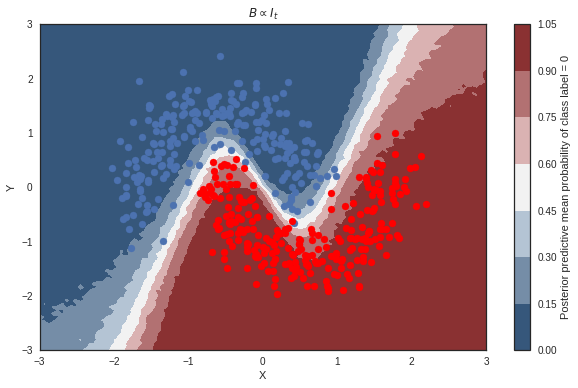

In [13]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
ax.set_title('$B \propto I_t $')
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

### Uncertainty in predicted value

So far, everything I showed we could have done with a non-Bayesian Neural Network. 
The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. 
However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:

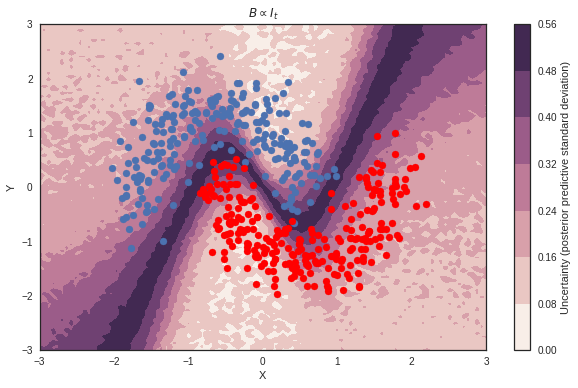

In [14]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
ax.set_title('$B \propto I_t $')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

## Next steps

This section was added with the introduction of the first approximate MCMC sampling algorithm in pymc3, Stochastic Gradient Fisher Scoring.
The file [sgmcmc.py]() defines a BaseStochasticGradient class that can be extended to other approximate algorithms by only implementing `_initialize_values` and `mk_training_fn` methods